![PCCMM](https://ccmmbigdata.cesga.es/static/images/public/benvida_banner_ccmm_v1.webp)

# **Plataforma BigData - Programa de Ciencias Mariñas de Galicia**

Benvido/a ó Programa de Ciencias Mariñas de Galicia. 

A plataforma BigData permite á comunidade mariña explorar e analizar os datos existentes dunha maneira integrada.

> **⚠️ ADVERTENCIA**: Actualmente a plataforma está na fase de proba de concepto (POC) para que a comunidade mariña poida probala, ver se satisfai as súas necesidades e ir orientando os desarollos futuros. Por iso agradecemos que nos fagades chegar calquera comentario ou petición sobre a mesma a ccmm@cesga.es.

Neste **caso de uso** imos traballar cos seguintes datos:
- Datos do HFR que proporciona mapas dá velocidade total dá corrente superficial ao longo dá costa galega.
- Datos dá temperatura superficial dá Boia de Cies.
- Datos calculados do índice de afloramento do HFR.

## Contidos
- 1. Temperatura superficial e o índice de afloramento
- 2. Corrente superficial e o índice de afloramento

Para comezar, importaremos o módulo e certas funcións necesarias para a correcta ejecucción do notebook:

In [1]:
import ccmm
import pandas as pd
import numpy as np
import pyspark.sql.functions as F
from datetime import datetime, timedelta
from pyspark.sql.functions import col, expr, min, max, to_date
from pyspark.sql.types import DateType
import matplotlib.pyplot as plt

## 1. Temperatura superficial e o índice de afloramento

### 1.1 Procesamento do dataframe ```eom_cies_tmps```

Cargamos el dataframe y obtenemos su estructura.

In [2]:
temperatura_sup = ccmm.load('eom_cies_tmps')
temperatura_sup.cache()
ccmm.describe('eom_cies_tmps')

root
 |-- MEDIDA: string (nullable = true)
 |-- VALOR: string (nullable = true)
 |-- CODIGO_VALIDACION: string (nullable = true)
 |-- DATA: string (nullable = true)



Realizamos un pequeño filtro para ver que rango de fechas tenemos disponibles.

In [3]:
# Aplicamos la conversión con PySpark para convertir DATA en un tipo de dato 'DateType'.
temperatura_sup = temperatura_sup.withColumn('DATA', to_date(temperatura_sup['DATA'], 'dd/MM/yyyy'))

fecha_mas_antigua = temperatura_sup.agg(min('DATA')).collect()[0][0]
fecha_mas_reciente = temperatura_sup.agg(max('DATA')).collect()[0][0]

print("Fecha más antigua:", fecha_mas_antigua)
print("Fecha más reciente:", fecha_mas_reciente)

Fecha más antigua: 2022-01-01
Fecha más reciente: 2023-10-19


Procesamos y filtramos el conjunto de datos para su posterior visualización.

In [4]:
# Convertimos el dataframe de temperaturas a Pandas para su procesamiento.
temperatura_sup_pd = temperatura_sup.toPandas()

# Convertimos la columna DATA a un objeto 'datetime' con Pandas.
temperatura_sup_pd['DATA'] = pd.to_datetime(temperatura_sup_pd['DATA'])

# Ordenamos el dataframe según la fecha.
temperatura_sup_pd.sort_values('DATA', inplace=True)

# Transformamos la columna VALOR en flotante y lo formateamos correctamente.
temperatura_sup_pd['VALOR'] = temperatura_sup_pd['VALOR'].str.replace(',', '.').astype(float)

# Transformamos la columna CODIGO_VALIDACION en entero.
temperatura_sup_pd['CODIGO_VALIDACION']= temperatura_sup_pd['CODIGO_VALIDACION'].astype(int)

# Filtramos que el contenido de VALOR sea mayor o igual que 0, para evitar datos erróneos.
temperatura_sup_pd = temperatura_sup_pd[temperatura_sup_pd['VALOR'] >= 0]

print(temperatura_sup_pd.head())

                     MEDIDA  VALOR  CODIGO_VALIDACION       DATA
0  Temperatura (Superficie)  13.72                  1 2022-01-01
1  Temperatura (Superficie)  13.83                  3 2022-01-02
2  Temperatura (Superficie)  13.91                  1 2022-01-03
3  Temperatura (Superficie)  13.86                  1 2022-01-04
4  Temperatura (Superficie)  13.44                  1 2022-01-05


Calcular la media móvil de 7 días.

In [5]:
dias = 7
temperatura_sup_pd['MEDIA_MOVIL'] = temperatura_sup_pd['VALOR'].rolling(window=dias).mean()
mov_temp_sup_pd = temperatura_sup_pd[temperatura_sup_pd.index % dias == 0]
print(mov_temp_sup_pd[['DATA', 'MEDIA_MOVIL']])

          DATA  MEDIA_MOVIL
0   2022-01-01          NaN
7   2022-01-08    13.558571
14  2022-01-15    13.481429
21  2022-01-22    13.285714
28  2022-01-29    13.311429
..         ...          ...
623 2023-09-16    18.161429
630 2023-09-23    18.425714
637 2023-09-30    19.208571
644 2023-10-07    19.727143
651 2023-10-14    19.281429

[92 rows x 2 columns]


### 1.2 Procesamento do dataframe ```hfrui```

Cargamos el dataframe y obtenemos su estructura.

In [6]:
hrfui = ccmm.load('hfrui')
ccmm.describe('hfrui')

root
 |-- TIME: string (nullable = true)
 |-- DEPTH: string (nullable = true)
 |-- LATITUDE: string (nullable = true)
 |-- LONGITUDE: string (nullable = true)
 |-- DEPH: string (nullable = true)
 |-- crs: string (nullable = true)
 |-- UI: string (nullable = true)



Procesamos y filtramos el conjunto de datos para su posterior visualización.

In [7]:
# Convertimos el dataframe de temperaturas a Pandas para su procesamiento.
hfrui_pd = hrfui.toPandas()

# Convertimos la columna TIME a un objeto 'datetime' con Pandas.
hfrui_pd['TIME'] = pd.to_datetime(hfrui_pd['TIME'])

# Transformamos la columna UI en flotante.
hfrui_pd['UI'] = hfrui_pd['UI'].astype(float)

# Filtramos la columna UI para su visualización.
hfrui_pd = hfrui_pd[(hfrui_pd['UI'] >= -10) & (hfrui_pd['UI'] <= 30)]

print(hfrui_pd.head())

          TIME DEPTH           LATITUDE           LONGITUDE DEPH crs  \
139 2022-03-20     0  42.51565170288086  -9.283395767211914  0.0   0   
162 2022-03-20     0  42.94774627685547  -9.356407165527344  0.0   0   
163 2022-03-20     0  43.00175476074219  -9.502429008483888  0.0   0   
234 2022-03-20     0   43.5958251953125  -8.626293182373047  0.0   0   
238 2022-03-20     0  43.64982986450195  -8.626293182373047  0.0   0   

            UI  
139  23.143280  
162  28.018944  
163  22.660288  
234  -7.581903  
238  21.323300  


Cálculamos la media móvil para 7 días.

In [8]:
hfrui_pd.set_index('TIME', inplace=True)
mov_ui_sup_pd = hfrui_pd.resample('7D').mean().reset_index()
mov_ui_sup_pd['UI'].interpolate(method='linear', inplace=True)
print(mov_ui_sup_pd.head(100))

         TIME         UI
0  2022-03-20  11.633474
1  2022-03-27   9.966579
2  2022-04-03  11.618341
3  2022-04-10  10.640966
4  2022-04-17   9.195602
..        ...        ...
77 2023-09-10  10.645396
78 2023-09-17  10.959936
79 2023-09-24  10.061746
80 2023-10-01   9.470794
81 2023-10-08   7.370855

[82 rows x 2 columns]


### 1.3 Representación gráfica

In [9]:
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource
from bokeh.io import output_notebook
from bokeh.models.formatters import DatetimeTickFormatter
from bokeh.models.tools import HoverTool

# Crear un objeto ColumnDataSource a partir de tu DataFrame de Pandas
source_temp = ColumnDataSource(temperatura_sup_pd)
source_mov_temp_sup_pd = ColumnDataSource(mov_temp_sup_pd)
source_hfrui = ColumnDataSource(hfrui_pd)
source_mov_hfrui = ColumnDataSource(mov_ui_sup_pd)

# Crear un gráfico de Bokeh
p = figure(plot_width=800, plot_height=400, x_axis_type='datetime', title='Evolución da temperatura superficial e do afloramento')

# Configurar los ejes y su formato
p.xaxis.axis_label = "Tiempo"
p.yaxis.axis_label = "Valores"
p.xaxis.formatter = DatetimeTickFormatter(days="%d %b %Y")

# Información en la superposición
hover_temp = HoverTool(renderers=[p.line(x='DATA', y='VALOR', source=mov_temp_sup_pd, line_width=2, line_color='blue', legend_label="Temperatura Superficial")])
hover_temp.tooltips = [("Fecha", "@DATA{%F}"), ("Temperatura", "@VALOR")]
hover_temp.formatters = {'@DATA': 'datetime'}
hover_hfrui = HoverTool(renderers=[p.line(x='TIME', y='UI', source=mov_ui_sup_pd, line_width=2, line_color='green', legend_label="UI")])
hover_hfrui.tooltips = [("Fecha", "@TIME{%F}"), ("UI", "@UI")]
hover_hfrui.formatters = {'@TIME': 'datetime'}

p.add_tools(hover_temp)
p.add_tools(hover_hfrui)
p.legend.title = "Medida"
p.legend.label_text_font_size = "12px"
p.legend.title_text_font_size = "14px"
p.legend.location = "bottom_left"
p.title.text_font_size = "16px"

output_notebook()
show(p)

Loading BokehJS ...

## 2. Corrente superficial e o índice de afloramento

In [10]:
hfrtemp = ccmm.load('hfrtemp')
ccmm.describe('hfrtemp')

root
 |-- TIME: string (nullable = true)
 |-- LATITUDE: double (nullable = true)
 |-- LONGITUDE: double (nullable = true)
 |-- EWCT: double (nullable = true)
 |-- NSCT: double (nullable = true)



In [11]:
hfrtemp_pd = hfrtemp.toPandas()
hfrtemp_pd['TIME'] = pd.to_datetime(hfrtemp_pd['TIME'])
hfrtemp_pd['MAGNITUD'] = np.sqrt(hfrtemp_pd['EWCT']**2 + hfrtemp_pd['NSCT']**2)
hfrtemp_pd_r = hfrtemp_pd.sample(n=500)
print(hfrtemp_pd)

                     TIME   LATITUDE  LONGITUDE   EWCT   NSCT  MAGNITUD
0     2023-05-11 20:00:00  40.624859  -9.648452 -0.657 -0.038  0.658098
1     2023-05-11 20:00:00  40.624859  -9.575440 -0.567 -0.103  0.576279
2     2023-05-11 20:00:00  40.624859  -9.502429 -0.586 -0.118  0.597762
3     2023-05-11 20:00:00  40.678890 -10.232543  0.516 -0.714  0.880938
4     2023-05-11 20:00:00  40.678890  -9.648452 -0.657 -0.038  0.658098
...                   ...        ...        ...    ...    ...       ...
48137 2023-05-11 14:00:00  44.675793  -9.210384 -0.156 -0.277  0.317907
48138 2023-05-11 14:00:00  44.675793  -9.137373 -0.076 -0.252  0.263211
48139 2023-05-11 14:00:00  44.675793  -9.064362 -0.038 -0.228  0.231145
48140 2023-05-11 14:00:00  44.675793  -8.991350  0.063 -0.228  0.236544
48141 2023-05-11 14:00:00  44.675793  -8.918339  0.072 -0.230  0.241006

[48142 rows x 6 columns]


In [12]:
from pyproj import Transformer

in_proj = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)
hfrtemp_pd_r["LONGITUDE_MERCATOR"], hfrtemp_pd_r["LATITUDE_MERCATOR"] = in_proj.transform(hfrtemp_pd_r["LONGITUDE"].values, hfrtemp_pd_r["LATITUDE"].values)
hfrtemp_pd_r = hfrtemp_pd_r[['TIME', 'LONGITUDE_MERCATOR', 'LATITUDE_MERCATOR', 'EWCT', 'NSCT', 'MAGNITUD']]
print(hfrtemp_pd_r.head())

hfrtemp_pd_r_source = ColumnDataSource(data=hfrtemp_pd_r)

                     TIME  LONGITUDE_MERCATOR  LATITUDE_MERCATOR   EWCT  \
33893 2023-05-11 16:00:00       -1.033423e+06       5.004828e+06 -0.149   
47192 2023-05-11 14:00:00       -1.260995e+06       5.336934e+06  0.026   
43550 2023-05-11 18:00:00       -1.049678e+06       5.436369e+06 -0.086   
8514  2023-05-11 10:00:00       -9.927849e+05       5.076758e+06  0.095   
38981 2023-05-11 13:00:00       -1.082188e+06       5.345180e+06 -0.149   

        NSCT  MAGNITUD  
33893 -0.331  0.362990  
47192 -0.202  0.203666  
43550 -0.101  0.132654  
8514  -0.138  0.167538  
38981 -0.231  0.274885  


In [13]:
from bokeh.plotting import figure, show
from bokeh.tile_providers import get_provider, Vendors
from bokeh.models import ColumnDataSource, Arrow, OpenHead, ColorBar, NormalHead, VeeHead, OpenHead, ArrowHead, TeeHead, HoverTool
from bokeh.transform import linear_cmap, transform
from bokeh.layouts import column
from bokeh.palettes import RdBu as colors
from bokeh.io import output_notebook, show

tile_provider = get_provider(Vendors.CARTODBPOSITRON)

tooltips = [("MAGNITUD", "@MAGNITUD")]
p = figure(
    x_range=(-1500000, -700000),
    y_range=(5000000, 5500000),
    x_axis_type="mercator",
    y_axis_type="mercator",
    tooltips=tooltips,
    plot_width=850,
    plot_height=700
)

p.add_tile(tile_provider)

palette = ['#d7191c', '#fdae61', '#a6d96a', '#1a9641']
mapper = linear_cmap(field_name='MAGNITUD', palette=palette, low=0, high=9)

# Calcula las coordenadas finales de las flechas
hfrtemp_pd_r_source.data['x_end'] = hfrtemp_pd_r_source.data['LONGITUDE_MERCATOR'] + hfrtemp_pd_r_source.data['EWCT']
hfrtemp_pd_r_source.data['y_end'] = hfrtemp_pd_r_source.data['LATITUDE_MERCATOR'] + hfrtemp_pd_r_source.data['NSCT']

arrows = Arrow(
    x_start="LONGITUDE_MERCATOR",
    y_start="LATITUDE_MERCATOR", 
    x_end="x_end",
    y_end="y_end",
    end=VeeHead(line_color="blue", fill_color="blue", line_width=0.5, size=10),
    line_width=1.5,
    source=hfrtemp_pd_r_source
)
p.add_layout(arrows)
p.title.text = 'Dirección e Intensidad de Corriente'
p.title.text_font_size = '16pt'
p.xaxis.axis_label = 'Longitud'
p.yaxis.axis_label = 'Latitud'

output_notebook()
show(p)

Loading BokehJS ...

Gráfico de dispersión que muestre la velocidad de la corriente en función de la longitud y la latitud.

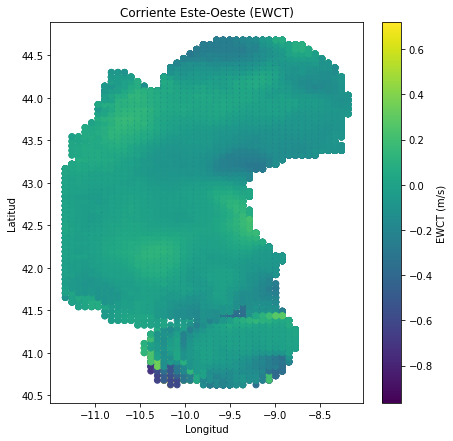

In [14]:
plt.figure(figsize=(7, 7))
plt.scatter(hfrtemp_pd['LONGITUDE'], hfrtemp_pd['LATITUDE'], c=hfrtemp_pd['EWCT'], cmap='viridis')
plt.title('Corriente Este-Oeste (EWCT)')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.colorbar(label='EWCT (m/s)')
plt.show()

Calculamos la media, la mediana, la desviación estándar, el mínimo y el máximo de las componentes de corriente para la corriente Este-Oeste.

In [15]:
ewct_mean = hfrtemp_pd['EWCT'].mean()
ewct_median = hfrtemp_pd['EWCT'].median()
ewct_std = hfrtemp_pd['EWCT'].std()
ewct_min = hfrtemp_pd['EWCT'].min()
ewct_max = hfrtemp_pd['EWCT'].max()

print(f'Media EWCT: {ewct_mean}')
print(f'Mediana EWCT: {ewct_median}')
print(f'Desviación Estándar EWCT: {ewct_std}')
print(f'Min EWCT: {ewct_min}')
print(f'Max EWCT: {ewct_max}')

Media EWCT: -0.11188204067730594
Mediana EWCT: -0.099500005
Desviación Estándar EWCT: 0.13529046346602175
Min EWCT: -0.96500003
Max EWCT: 0.71900004


Gráfico de dispersión simple que muestra la relación entre las variables NSCT y EWCT en un gráfico bidimensional.

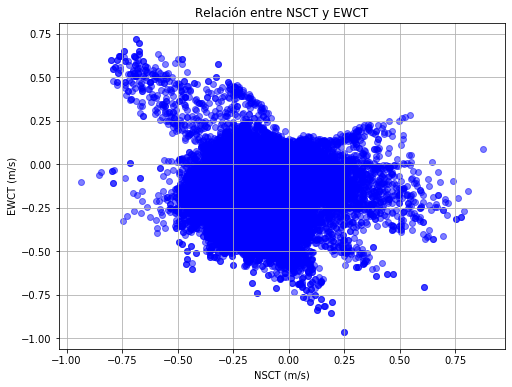

In [16]:
# Ejemplo de gráfico de dispersión de EWCT en función de NSCT
plt.figure(figsize=(8, 6))
plt.scatter(hfrtemp_pd['NSCT'], hfrtemp_pd['EWCT'], c='b', alpha=0.5)
plt.title('Relación entre NSCT y EWCT')
plt.xlabel('NSCT (m/s)')
plt.ylabel('EWCT (m/s)')
plt.grid(True)
plt.show()

In [17]:
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, ColorBar, HoverTool
from bokeh.transform import linear_cmap, transform
from bokeh.palettes import Viridis256
from bokeh.io import output_notebook, show
from bokeh.tile_providers import get_provider, Vendors

# Crear una fuente de datos de Bokeh
source = ColumnDataSource(data=hfrtemp_pd)

# Crear una paleta de colores basada en la variable EWCT
mapper = linear_cmap(field_name='EWCT', palette=Viridis256, low=hfrtemp_pd['EWCT'].min(), high=hfrtemp_pd['EWCT'].max())

# Crear una figura de Bokeh
p = figure(plot_width=800, plot_height=600, title="Relación entre NSCT y EWCT")
p.circle('NSCT', 'EWCT', source=source, size=8, color=mapper, legend_field='EWCT')

# Personalizar la figura
p.xaxis.axis_label = "NSCT (m/s)"
p.yaxis.axis_label = "EWCT (m/s)"

# Agregar una barra de color
color_bar = ColorBar(color_mapper=mapper['transform'], width=10, location=(0,0))
p.add_layout(color_bar, 'right')

output_notebook()
show(p)

Loading BokehJS ...